# Density evaluation

In [1]:
# import libraries
import sklearn
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

# Loading dataset

In [2]:
dataset_path='/path/to/dataset/'   # modify the dataset_path to your own dir
assert dataset_path!='' and dataset_path!='/path/to/dataset/', 'Please specify the dataset_path!'

path_photos = dataset_path+'Dataset indiano/'
patch_size=48        # patch image size

# load csv file
df = pd.read_csv(dataset_path+'hbvalue.csv', sep=';')

# cut the dataset only to indian dataset
df = df[df['dataset']=='ind']

df.head()

,dataset,paziente,foto1,foto2,hb,Nome Cognome,Sesso,Et?,Data Nascita,buona,Unnamed: 10
91,ind,1,20200118_164759,20200118_164733,"12,2",NaN,M,29,NaN,NaN,NaN
92,ind,2,20200124_154320,20200124_154319,8,NaN,F,36,NaN,NaN,NaN
93,ind,3,20200124_155439,20200124_155418,"10,7",NaN,F,30,NaN,NaN,NaN
94,ind,4,20200124_160524,20200124_160522,"8,3",NaN,F,39,NaN,NaN,NaN
95,ind,5,20200124_161455,20200124_161452,"7,8",NaN,F,29,NaN,NaN,NaN


# Loading photos

In [3]:
def normal_normalized_single(imgs,mask):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[2]):
        imgs_normalized[:,:,i] = ((imgs_normalized[:,:,i] - np.min(imgs_normalized[:,:,i])) / (np.max(imgs_normalized[:,:,i])-np.min(imgs_normalized[:,:,i])))*255
    return imgs_normalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles"
# (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual.
#  So in a small area, histogram would confine to a small region (unless there is noise). 
# If noise is there, it will be amplified. To avoid this, contrast limiting is applied. 
# If any histogram bin is above the specified contrast limit (by default 40 in OpenCV),
#  those pixels are clipped and distributed uniformly to other bins before applying histogram equalization.
#  After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized_single(imgs):
  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
  imgs_equalized = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    imgs_equalized[:,:,i] = clahe.apply(np.array(imgs[:,:,i], dtype = np.uint8))
  return imgs_equalized


def adjust_gamma_single(imgs, gamma=1.0):
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
  # apply gamma correction using the lookup table
  new_imgs = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    new_imgs[:,:,i] = cv2.LUT(np.array(imgs[:,:,i], dtype = np.uint8), table)
  return new_imgs

def preprocess_single(image,mask):
  
  assert np.max(mask)==1
  image=np.array(image)
  image[:,:,0]=image[:,:,0]*mask
  image[:,:,1]=image[:,:,1]*mask
  image[:,:,2]=image[:,:,2]*mask

  image=normal_normalized_single(image,mask)
  image=clahe_equalized_single(image)
  image=adjust_gamma_single(image,0.8)
  image=image/255.0
  return image


def load_test_data(image):
  #image=tf.image.decode_jpeg(image,channels=1)
  #print(image.shape)
  image=tf.image.resize(image,[patch_size,patch_size])
  #image/=255.0
  return image

# pad images
def padding_images(image,mask,stride):
    h,w=image.shape[:2]
    new_h,new_w=h,w
    while (new_h-patch_size)%stride!=0:
        new_h+=1
    while (new_w-patch_size)%stride!=0:
        new_w+=1
    pad_image=np.zeros((new_h,new_w,3))
    pad_image[:h,:w,:]=image
    
    pad_mask=np.zeros((new_h,new_w))
    pad_mask[:h,:w]=mask
    
    return pad_image,pad_mask

# images to patches
def img2patch_list(image,stride=patch_size):
    patch_list=[]
    #image_binary=0.8*image[:,:,1:2]+0.2*image[:,:,2:3]  
    for j in range(0,image.shape[1]-patch_size+1,stride):
        for i in range(0,image.shape[0]-patch_size+1,stride):
            patch=image[i:i+patch_size,j:j+patch_size,:]
            patch_list.append(patch)
    return patch_list

# patches to image
def patchlist2image(patch_list,stride,image_shape):
    result=np.zeros(image_shape[:2])
    sum_matrix=np.zeros(image_shape[:2])
    index_x,index_y=0,0
    for i in range(patch_list.shape[0]):
        patch=patch_list[i,:,:,0]
        #patch=np.where(patch>0.5,1,0)
        #print(patch)
        result[index_x:index_x+patch_size,index_y:index_y+patch_size]+=patch
        sum_matrix[index_x:index_x+patch_size,index_y:index_y+patch_size]+=1
        index_x+=stride
        if index_x+patch_size>image_shape[0]:
            index_x=0
            index_y+=stride
    return result/sum_matrix

  0%|          | 0/90 [00:00<?, ?it/s]

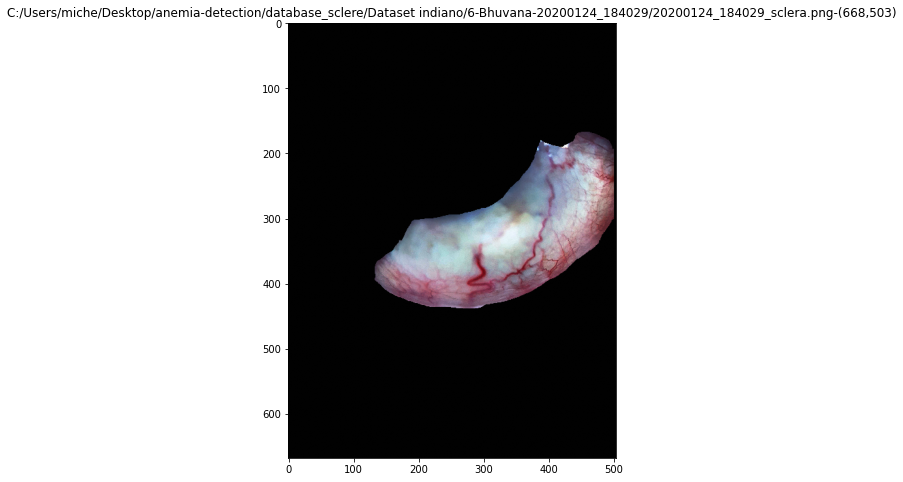

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/6-Bhuvana-20200124_184029/20200124_184029_sclera.png


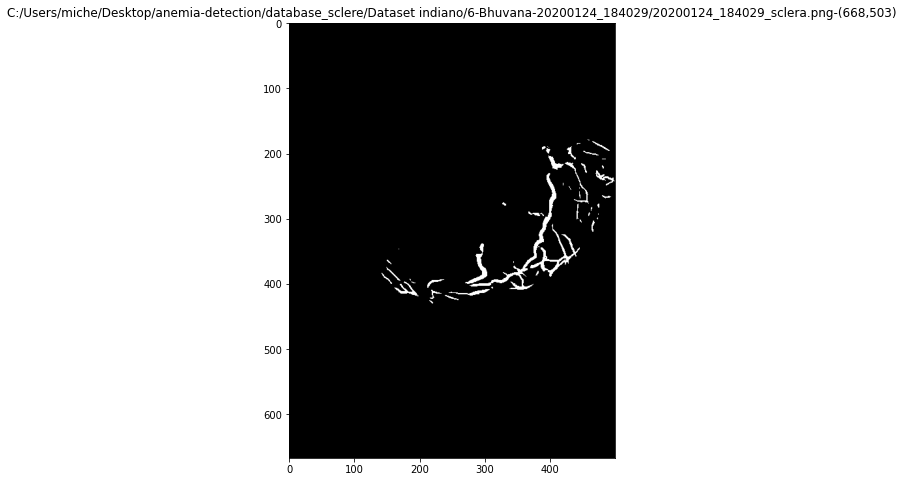

  1%|          | 1/90 [04:20<6:25:45, 260.06s/it]

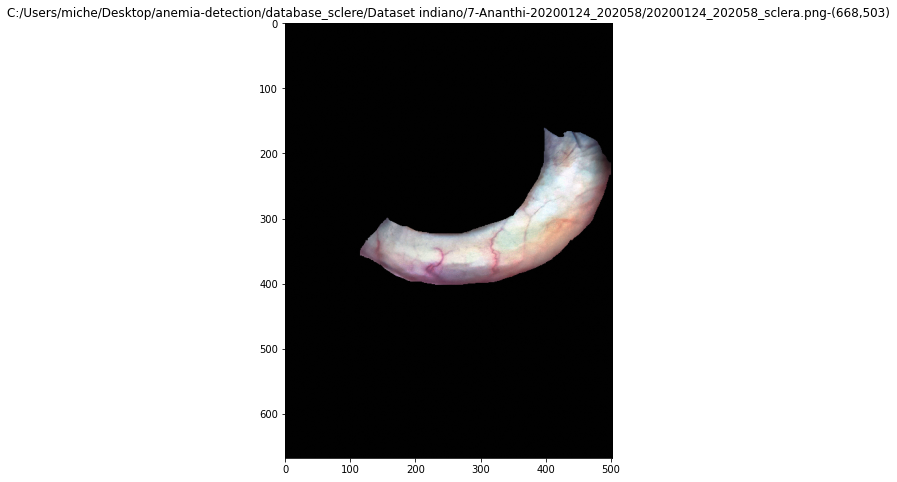

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/7-Ananthi-20200124_202058/20200124_202058_sclera.png


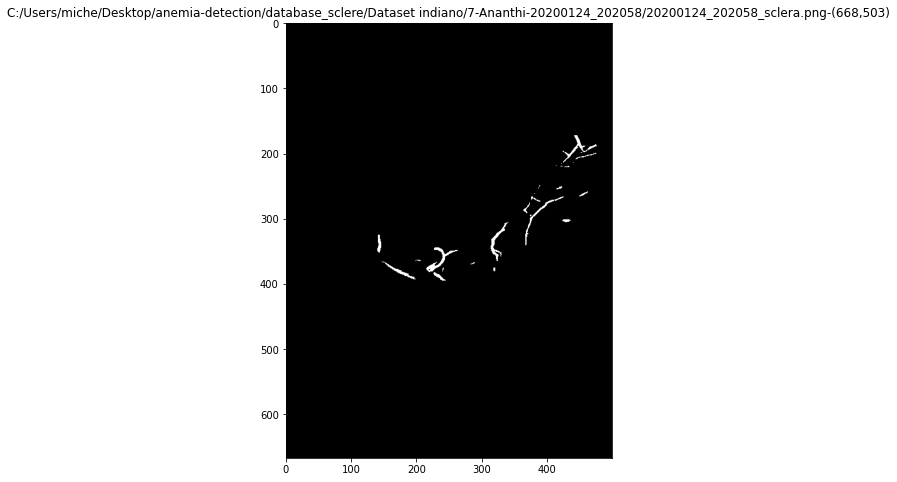

  2%|▏         | 2/90 [08:37<6:19:18, 258.61s/it]

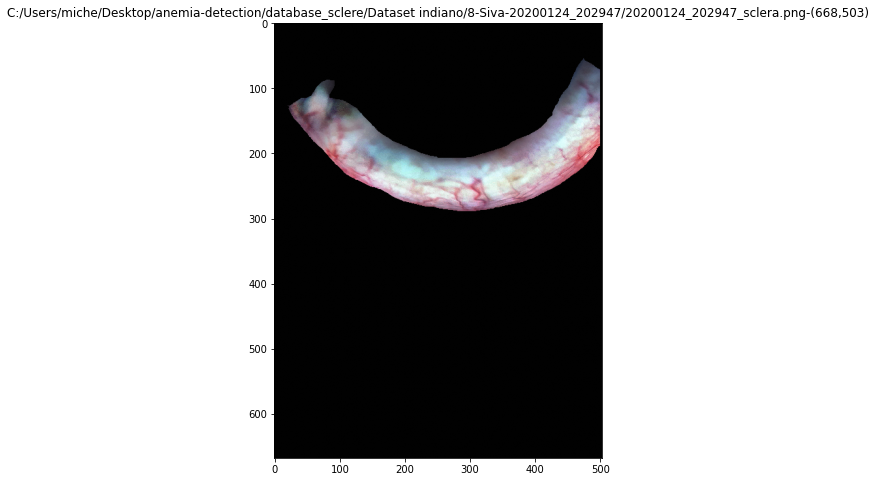

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/8-Siva-20200124_202947/20200124_202947_sclera.png


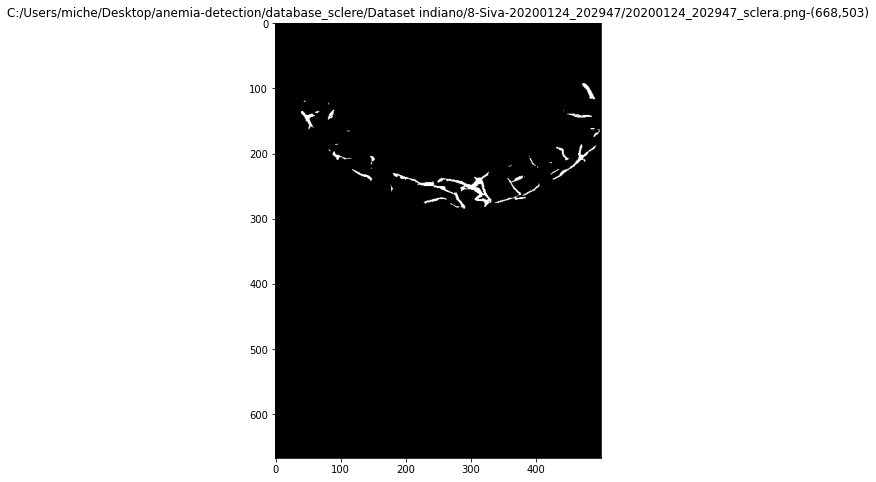

  3%|▎         | 3/90 [12:50<6:11:19, 256.08s/it]

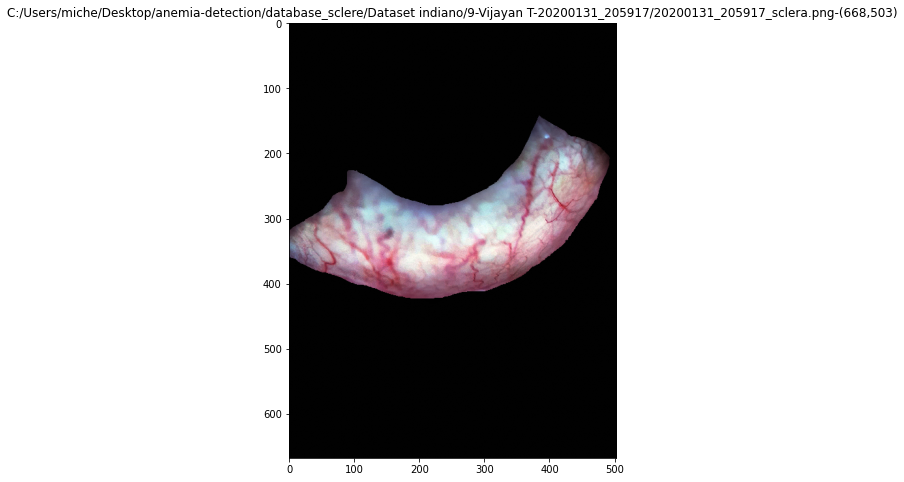

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/9-Vijayan T-20200131_205917/20200131_205917_sclera.png


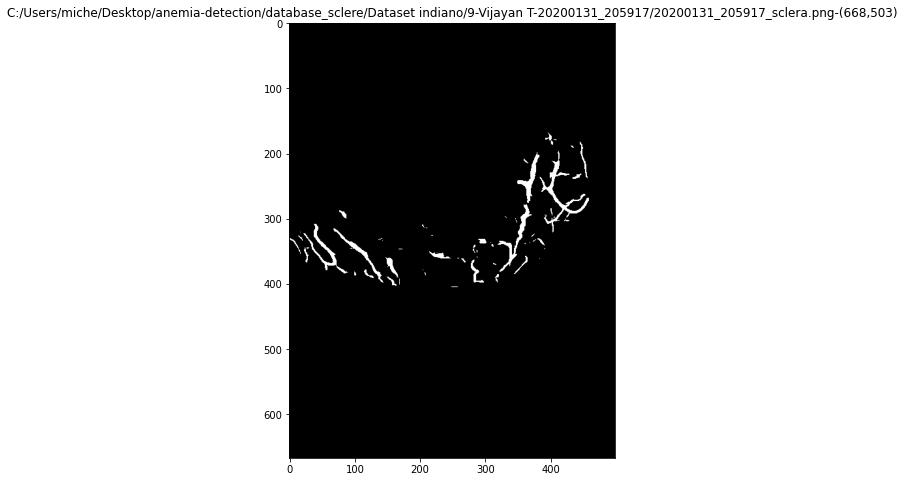

  4%|▍         | 4/90 [16:59<6:03:07, 253.34s/it]

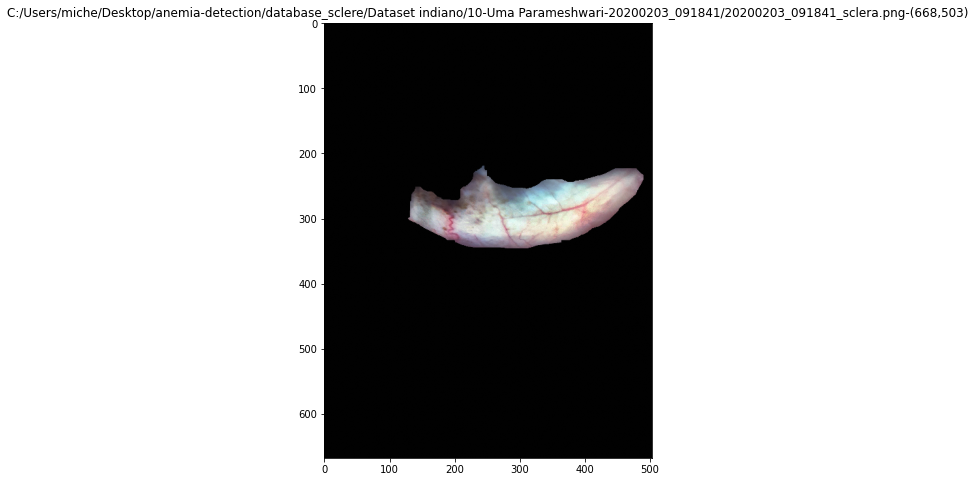

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/10-Uma Parameshwari-20200203_091841/20200203_091841_sclera.png


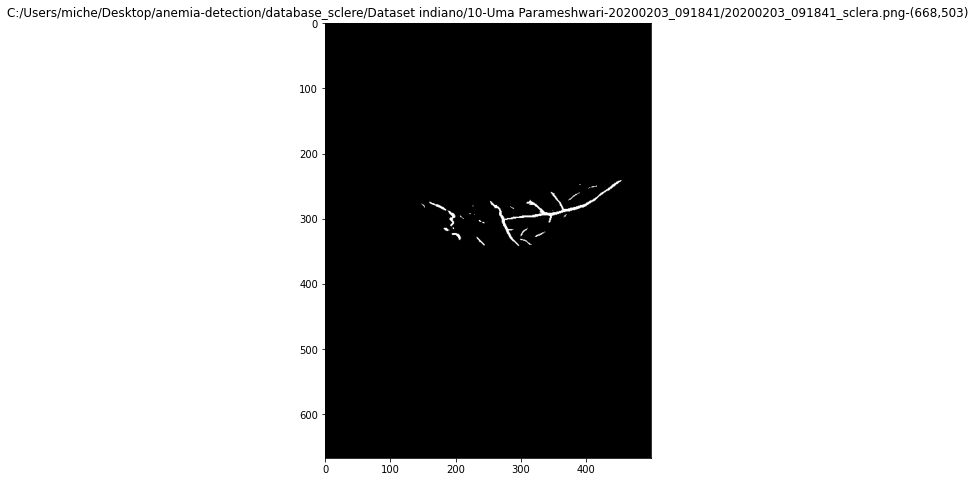

  6%|▌         | 5/90 [21:10<5:57:19, 252.22s/it]

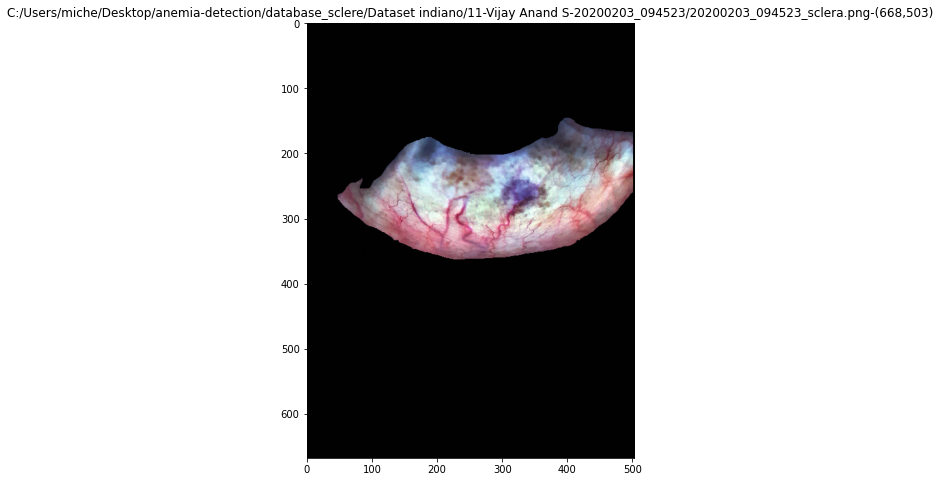

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/11-Vijay Anand S-20200203_094523/20200203_094523_sclera.png


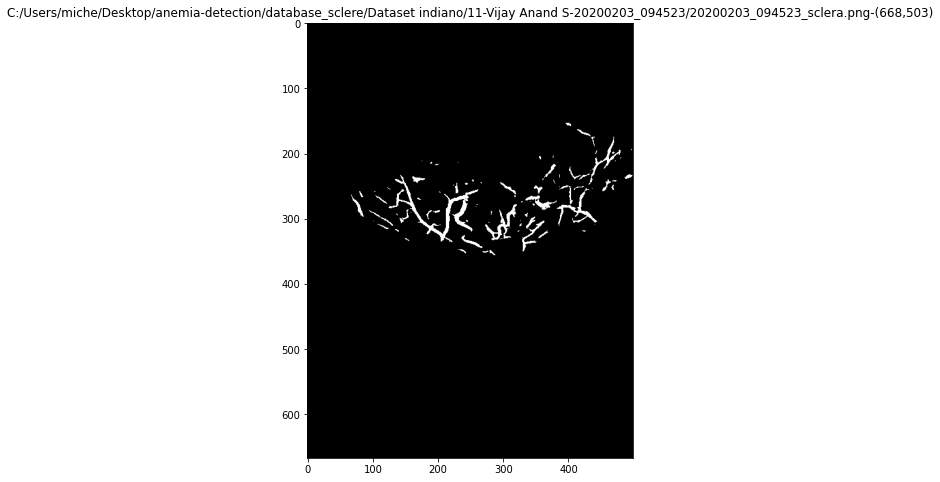

  7%|▋         | 6/90 [25:12<5:48:27, 248.90s/it]

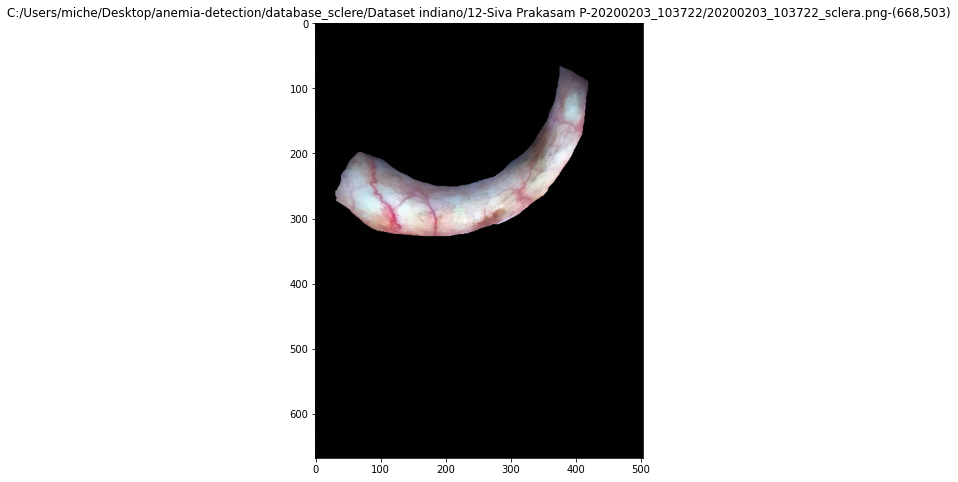

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/12-Siva Prakasam P-20200203_103722/20200203_103722_sclera.png


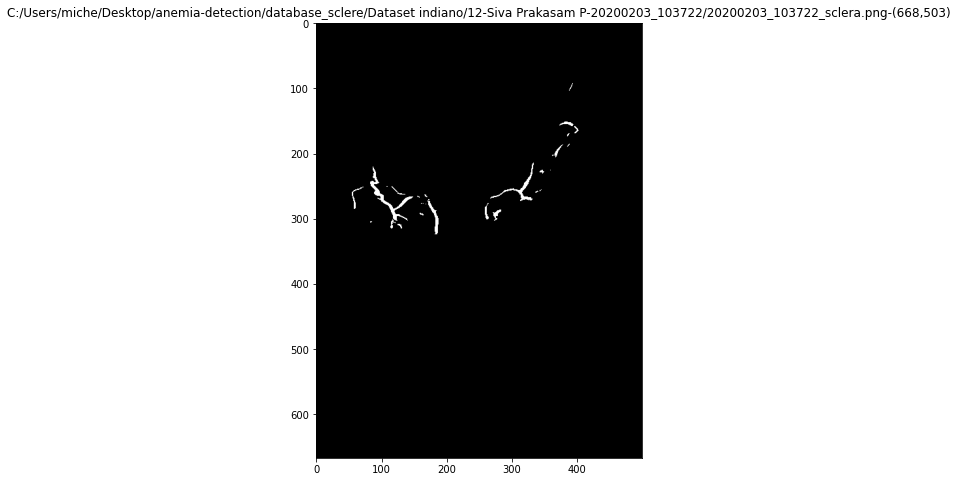

  8%|▊         | 7/90 [29:06<5:37:19, 243.84s/it]

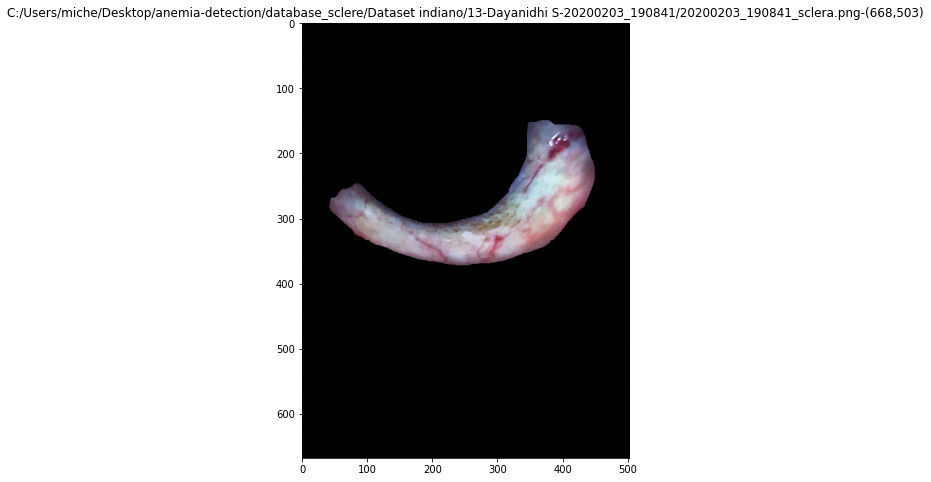

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/13-Dayanidhi S-20200203_190841/20200203_190841_sclera.png


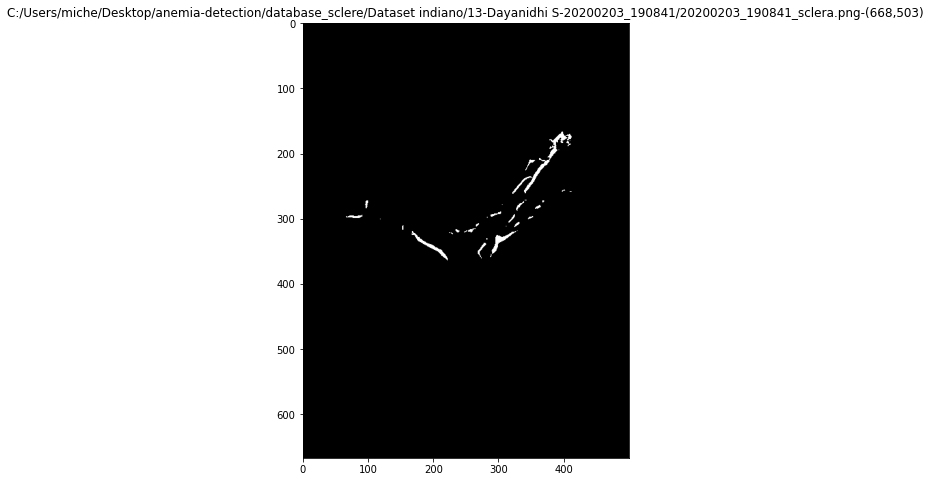

  9%|▉         | 8/90 [33:01<5:29:49, 241.34s/it]

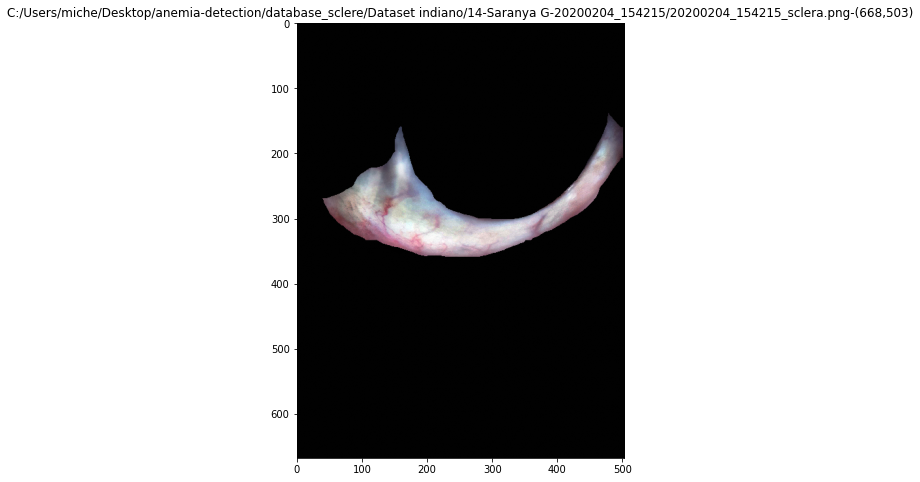

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/14-Saranya G-20200204_154215/20200204_154215_sclera.png


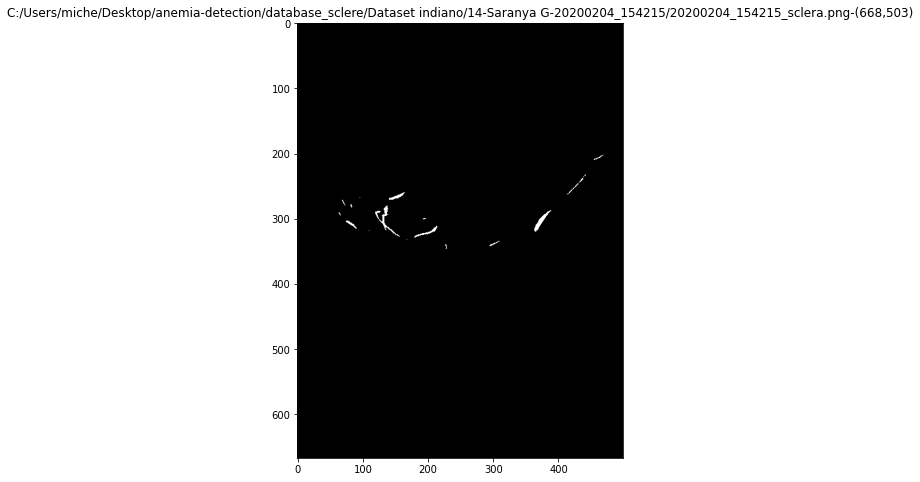

 10%|█         | 9/90 [37:12<5:29:30, 244.08s/it]

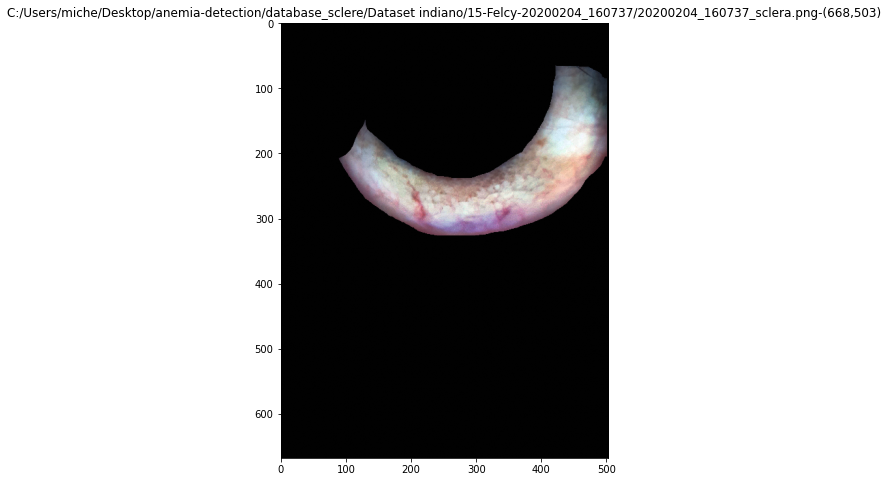

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/15-Felcy-20200204_160737/20200204_160737_sclera.png


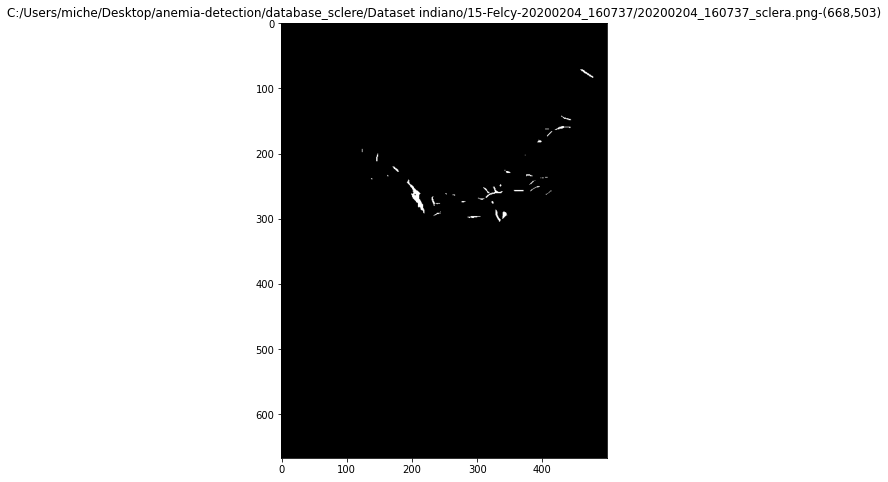

 11%|█         | 10/90 [41:30<5:31:08, 248.36s/it]

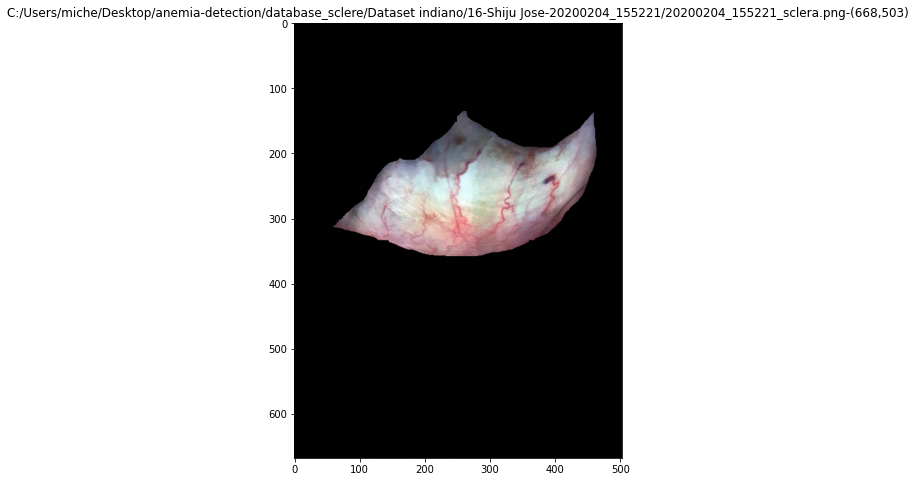

post processing: C:/Users/miche/Desktop/anemia-detection/database_sclere/Dataset indiano/16-Shiju Jose-20200204_155221/20200204_155221_sclera.png


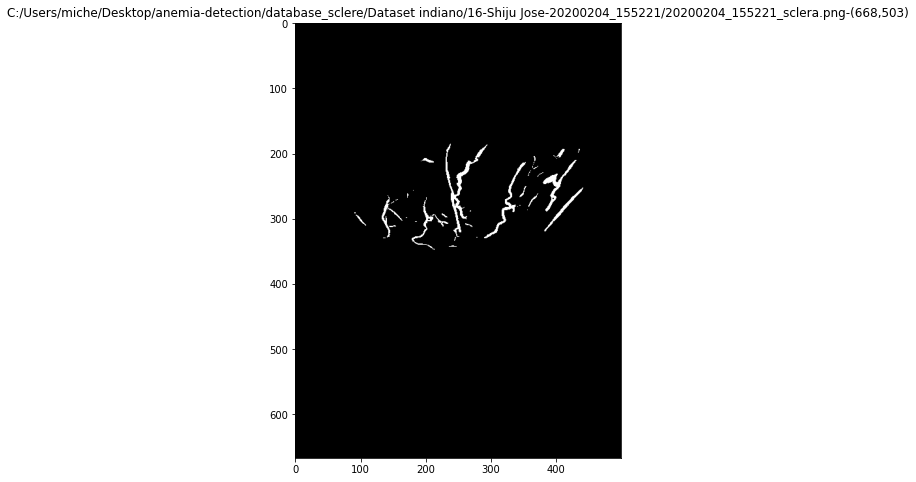

 12%|█▏        | 11/90 [45:41<5:28:04, 249.18s/it]

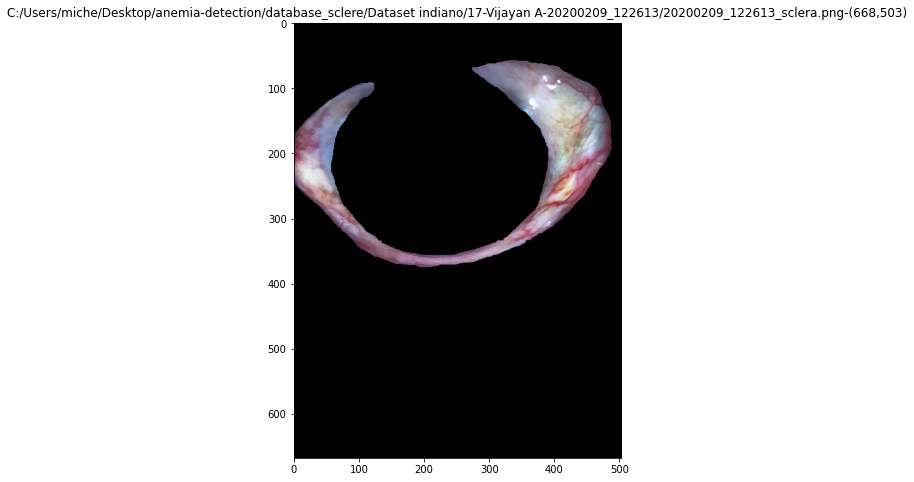

In [4]:
model_unet= tf.keras.models.load_model("pretrained_model")
stride=5

for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(row['paziente'] + "-") and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]

            image_name=path_single_photo + "/" + name_photo + '_sclera.png'
            
            # load and process test images
            image=plt.imread(image_name)
            image[image[:, :, 3] == 0] = [0, 0, 0, 0]
            image = cv2.resize(image, (500, 667))
            original_shape=image.shape

            # generate mask
            mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            mask=np.where(mask>0,1,0)

            image = image[:, :, :3]  # Rimuovi il canale alfa
            # image to patches
            image,pad_mask=padding_images(image,mask,stride)

            image=preprocess_single(image,pad_mask)
            test_patch_list=img2patch_list(image,stride)

            # visualize the image
            plt.figure(figsize=(8,8))
            plt.title(image_name+"-("+str(image.shape[0])+","+str(image.shape[1])+")")
            plt.imshow(image,cmap=plt.cm.gray)
            plt.show()

            # test dataloader
            test_dataset=tf.data.Dataset.from_tensor_slices(test_patch_list)
            test_dataset=test_dataset.map(load_test_data)
            test_dataset=test_dataset.batch(64)
            pred_result=[]
            
            # test process
            for batch, patch in enumerate(test_dataset):
                _,pred=model_unet(patch,training=False)
                
                pred=pred.numpy()
                pred_result.append(pred)
            pred_result=np.concatenate(pred_result,axis=0)
            
            # patches to image
            print("post processing:",image_name)
            pred_image=patchlist2image(pred_result,stride,image.shape)
            
            pred_image=pred_image[:original_shape[0],:original_shape[1]]

            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
            
            mask = cv2.erode(mask.astype(np.uint8), kernel)

            pred_image=pred_image*mask
            pred_image=np.where(pred_image>0.5,1,0)
                
            # visualize the test result
            plt.figure(figsize=(8,8))
            plt.title(image_name+"-("+str(image.shape[0])+","+str(image.shape[1])+")")
            plt.imshow(pred_image,cmap=plt.cm.gray)
            plt.show()

            plt.imsave(path_single_photo + "/" + name_photo + '_sclera_vessels_auto_deep.png',pred_image,cmap = plt.cm.gray)

            break